In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
import seaborn as sns

from sklearn.preprocessing import StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

In [3]:
train_df = pd.read_csv('../training.csv') # split for test and train set is ready
test = pd.read_csv('../test.csv')

# Load preprocessed data

In [4]:
y_train = pd.read_csv("../preprocessed_data/y_train.csv")
y = pd.read_csv("../preprocessed_data/y_whole.csv")
y_val  = pd.read_csv("../preprocessed_data/y_val.csv")

In [5]:
X_train = pd.read_csv("../preprocessed_data/X_train.csv")
X_whole = pd.read_csv("../preprocessed_data/X_whole.csv")
X_val  = pd.read_csv("../preprocessed_data/X_val.csv")

In [6]:
X_test  = pd.read_csv("../preprocessed_data/X_test.csv")

# 4. Random Forest Classifier



In [24]:
from sklearn.ensemble import RandomForestClassifier    
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [22]:
rf_base = RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42)
rf_base.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)

In [23]:
y_pred = rf_base.predict(X_val)

In [10]:
print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

           0       1.00      0.90      0.94     21248
           1       0.21      0.86      0.33       647

    accuracy                           0.90     21895
   macro avg       0.60      0.88      0.64     21895
weighted avg       0.97      0.90      0.93     21895



In [11]:
confusion_matrix(y_val, y_pred)

array([[19109,    93],
       [ 2139,   554]], dtype=int64)

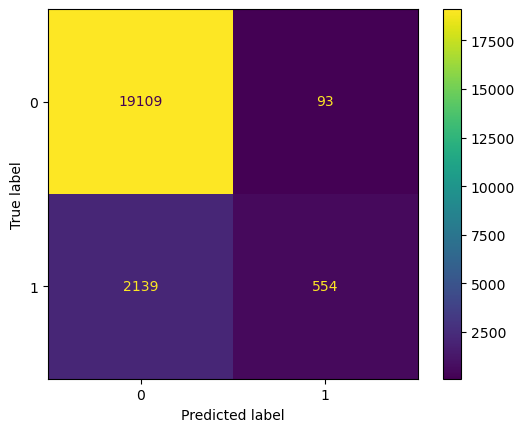

In [27]:
cm = confusion_matrix(y_val, y_pred, labels=rf_base.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=rf_base.classes_)
disp.plot()

In [28]:
from sklearn import metrics
import shap

def gini_roc(y_test, y_pred_proba, tytul):
    
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    
    plt.plot(fpr,tpr)
    plt.title(tytul)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    roc_auc = metrics.auc(fpr, tpr)
    gini = (2 * roc_auc) - 1

    return gini

def gini_train_val(model, X_train, y_train, X_val, y_val):
    
    y_pred_proba = model.predict_proba(X_train)[::,1]
    gini_train = gini_roc(y_train, y_pred_proba, "ROC Curve for Training Sample")
    print("gini_train: %.4f" % gini_train)
    
    y_pred_proba = model.predict_proba(X_val)[::,1]
    gini_val = gini_roc(y_val, y_pred_proba, "Roc Curve for Validation Sample")
    print("gini_val: %.4f" % gini_val)

    return

def shapley(model, X_train, X_val):
        
    # explain the model's predictions using SHAP
    # (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
    # model = lr
   
    explainer = shap.Explainer(model, X_train)
    
    shap_values = explainer(X_train)
    shap.summary_plot(shap_values, X_train)
    # visualize the first prediction's explanation
    shap.plots.waterfall(shap_values[0])

    # freature importance    
    shap.summary_plot(shap_values, X_train, plot_type="bar")
    
    shap.plots.bar(shap_values)
    shap.summary_plot(shap_values, plot_type='violin')
    shap.plots.bar(shap_values[0])
    shap.plots.waterfall(shap_values[0])
    shap.plots.force(shap_values[0])
    
    
    shap.plots.force(shap_values[1])
    
    shap.plots.heatmap(shap_values)
    
    # fig = shap.force_plot(explainer.expected_value, shap_values.values, X_train, feature_names = X_train.columns)
    # fig.savefig('testplot.png')
    # fig.plot()
    
    # fig = shap.force_plot(shap_values, X_train)
    # fig.plot()
   
    shap_values = explainer(X_val)
    shap.plots.beeswarm(shap_values)
    # visualize the first prediction's explanation
    shap.plots.waterfall(shap_values[0])
    
    # freature importance
    shap.summary_plot(shap_values, X_val, plot_type="bar")    
    
    

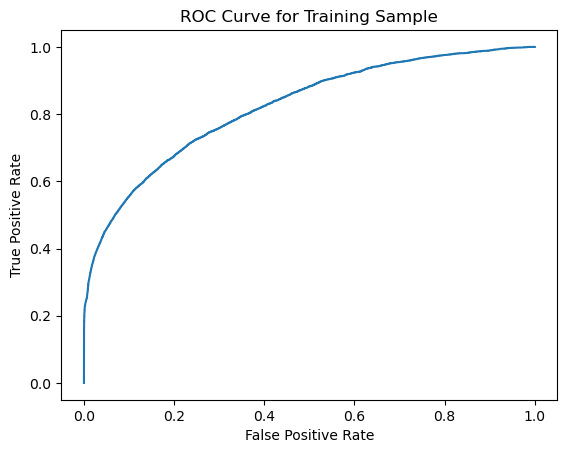

gini_train: 0.6434


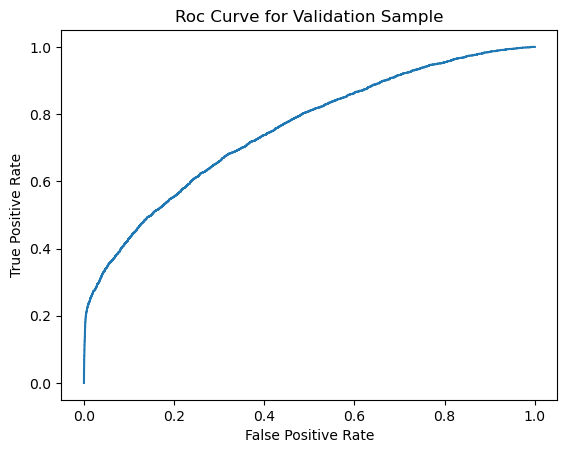

gini_val: 0.5081


In [29]:
gini_train_val(rf_base, X_train, y_train, X_val, y_val)

# 5. Parameter Tuning

In [29]:
import pickle


In [ ]:
k_values = [i for i in range (5,31,2)]
scores = []

for k in k_values:
    rf = RandomForestClassifier(max_depth=k)
    score = cross_val_score(rf, X_whole, y, cv=5)
    scores.append(np.mean(score))
    print(f"{k} job done")

KeyboardInterrupt: 

Text(0, 0.5, 'Accuracy Score')

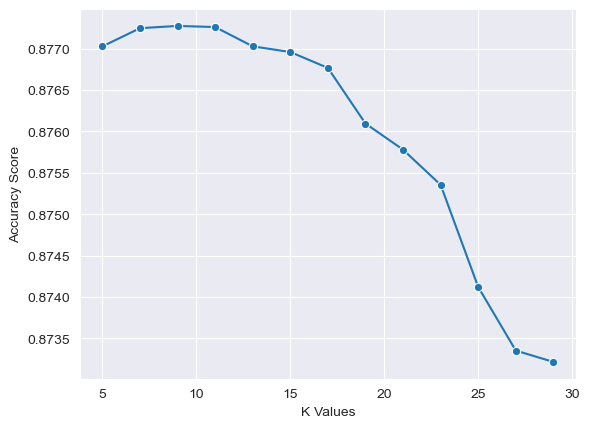

In [45]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("Max tree depth")
plt.ylabel("Accuracy Score")

In [30]:
grid_params = {'bootstrap': [True, False],
 'max_depth': [5, 8, 10, 12, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['log2', 'sqrt', None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'criterion' : ['gini','entropy', 'log_loss'],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}



In [31]:
rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = grid_params, n_iter = 50, cv = 2, verbose=3, random_state=42, n_jobs = -1)

In [38]:
gs = GridSearchCV(RandomForestClassifier(), grid_params, verbose = 3, cv=3, n_jobs = -1, scoring = ('balanced_accuracy'))

In [32]:
rf_random.fit(X_train, y)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [5, 8, 10, 12, 15, 20, 30,
                                                      40, 50, 60, 70, 80, 90,
                                                      100, None],
                                        'max_features': ['log2', 'sqrt', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=3)

In [33]:
rf_random.best_params_ # tutaj bedzie robil po accuracy - czy to git ? zobaczymy

{'n_estimators': 600,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': None,
 'max_depth': 5,
 'criterion': 'log_loss',
 'bootstrap': True}

{'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 90,
 'criterion': 'log_loss',
 'bootstrap': False}

In [34]:
filename = "saved_models/rf_random_2.sav"
pickle.dump(rf_random.best_estimator_, open(filename, 'wb'))


{'criterion': 'entropy', 'max_depth': 5, 'max_features': None}

those are the results - now training with those params

In [30]:
rf = RandomForestClassifier(n_jobs=-1, criterion= 'entropy', max_depth= 5, max_features= None, n_estimators=1000, random_state=42)
rf.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(criterion='entropy', max_depth=5, max_features=None,
                       n_estimators=1000, n_jobs=-1, random_state=42)

In [31]:
y_pred = rf.predict(X_val)

In [16]:
print(classification_report(y_pred, y_val)) # those results ain't anyhow better

              precision    recall  f1-score   support

           0       0.99      0.90      0.94     21193
           1       0.21      0.82      0.34       702

    accuracy                           0.90     21895
   macro avg       0.60      0.86      0.64     21895
weighted avg       0.97      0.90      0.92     21895



In [17]:
confusion_matrix(y_val, y_pred)

array([[19074,   128],
       [ 2119,   574]], dtype=int64)

# feature importance

In [18]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)
importance_df.head(10)

,feature,importance
14,x5,0.622853
3,VehicleAge,0.083806
82,x73,0.081180
101,x92,0.078825
1,VehBCost,0.053859
0,VehOdo,0.012654
4,MMRAcquisitionAuctionAveragePrice,0.012502
102,x93,0.009899
2,WarrantyCost,0.006343
5,MMRCurrentAuctionAveragePrice,0.006335


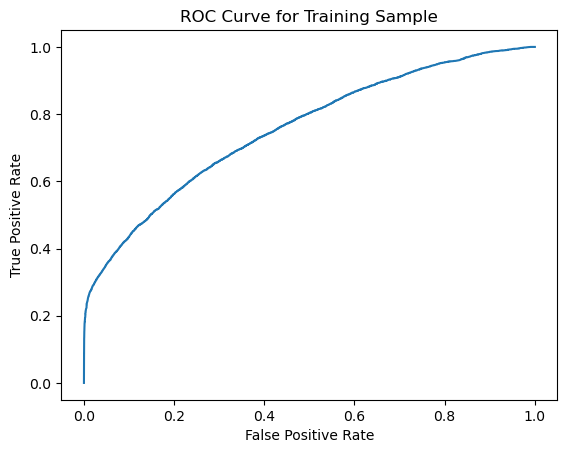

gini_train: 0.5099


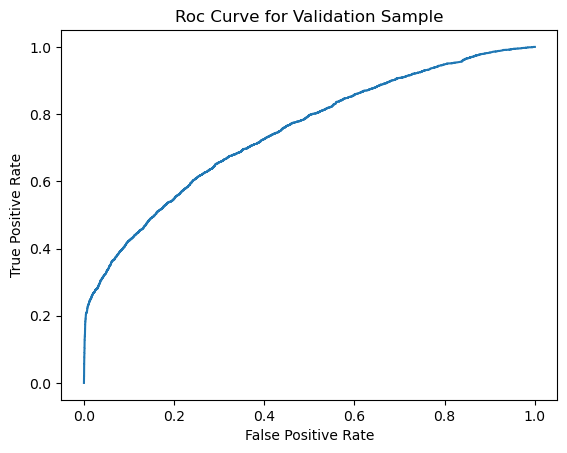

gini_val: 0.4929


In [21]:
gini_train_val(rf, X_train, y_train, X_val, y_val)

no tak srednio bym powiedzial

In [32]:
shapley(rf, X_train, X_val)

 32%|======              | 32586/102176 [17:27<37:15]       

# Final outputs

In [138]:
test = pd.read_csv('../test.csv')

In [139]:
X_test = test.copy()
X_test

,RefId,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,73015,12/2/2009,ADESA,2005,4,PONTIAC,GRAND PRIX,Bas,4D SEDAN,SILVER,...,8557.0,9752.0,NaN,NaN,18881,30212,GA,6500.0,0,2152
1,73016,12/2/2009,ADESA,2005,4,CHEVROLET,MALIBU V6,LS,4D SEDAN LS,SILVER,...,7562.0,9296.0,NaN,NaN,18111,30212,GA,6300.0,0,1118
2,73017,12/2/2009,ADESA,2006,3,DODGE,DURANGO 2WD V8,Adv,4D SUV 4.7L ADVENTURER,SILVER,...,15340.0,16512.0,NaN,NaN,18111,30212,GA,9700.0,0,1215
3,73018,12/2/2009,ADESA,2002,7,SATURN,L SERIES,L20,4D SEDAN L200,GOLD,...,5725.0,6398.0,NaN,NaN,18881,30212,GA,4150.0,0,1933
4,73019,12/2/2009,ADESA,2007,2,HYUNDAI,ACCENT,GS,2D COUPE GS,BLUE,...,5914.0,7350.0,NaN,NaN,18111,30212,GA,4100.0,0,920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48702,121742,11/17/2010,MANHEIM,2005,5,FORD,FIVE HUNDRED,SEL,4D SEDAN SEL,BLACK,...,9764.0,11395.0,NaN,NaN,20928,33411,FL,7955.0,0,1633
48703,121743,11/17/2010,MANHEIM,2007,3,TOYOTA,COROLLA,CE,4D SEDAN CE,GREEN,...,10283.0,11565.0,NaN,NaN,20928,33411,FL,7035.0,0,594
48704,121744,11/17/2010,MANHEIM,2006,4,KIA,SPECTRA,EX,4D SEDAN EX,BLACK,...,7871.0,9490.0,NO,GREEN,20928,33411,FL,6335.0,0,594
48705,121745,11/17/2010,MANHEIM,2005,5,MAZDA,MAZDA3,s,4D SEDAN GT,SILVER,...,8576.0,9937.0,NO,GREEN,20928,33411,FL,8055.0,0,1038


In [140]:
X_test = prepipe.transform(X_test)
X_test = pipeline.transform(X_test)
X_test = pd.DataFrame(X_test, columns=colnames)

Categorical columns transformed.
MMR Columns imputed.
Done preprocessing


In [141]:
y = rf.predict(X_test)
pd.DataFrame(y, columns=["IsBadBuy"]).join(test["RefId"]).to_csv("../out.csv", index=False)